# Public Transit Information With Python
## Elad Alfassa

### [eladalfassa.com](https://eladalfassa.com)
### [curlbus.app](https://curlbus.app)

# GTFS
## General Transit Feed Specification

https://developers.google.com/transit/gtfs/

ftp://gtfs.mot.gov.il/

<img src="ftp_index.png">

<img src="zip.png">

<img src="GTFS_data_model_diagram.PNG">

In [1]:
%matplotlib notebook
import geopy.distance
import pandas
import matplotlib.pyplot as plt
radius_in_km = 1
HERE = (32.0863190, 34.7750020)

# Create a square bounding box around the given position
distance = geopy.distance.distance()
north = distance.destination(HERE, 0, radius_in_km).latitude
east = distance.destination(HERE, 90, radius_in_km).longitude
south = distance.destination(HERE, 180, radius_in_km).latitude
west = distance.destination(HERE, -90, radius_in_km).longitude

# Query for stops within the bounding box
with open("stops.txt", "r") as f:
    data = pandas.read_csv(f, quoting=3)

/home/elad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


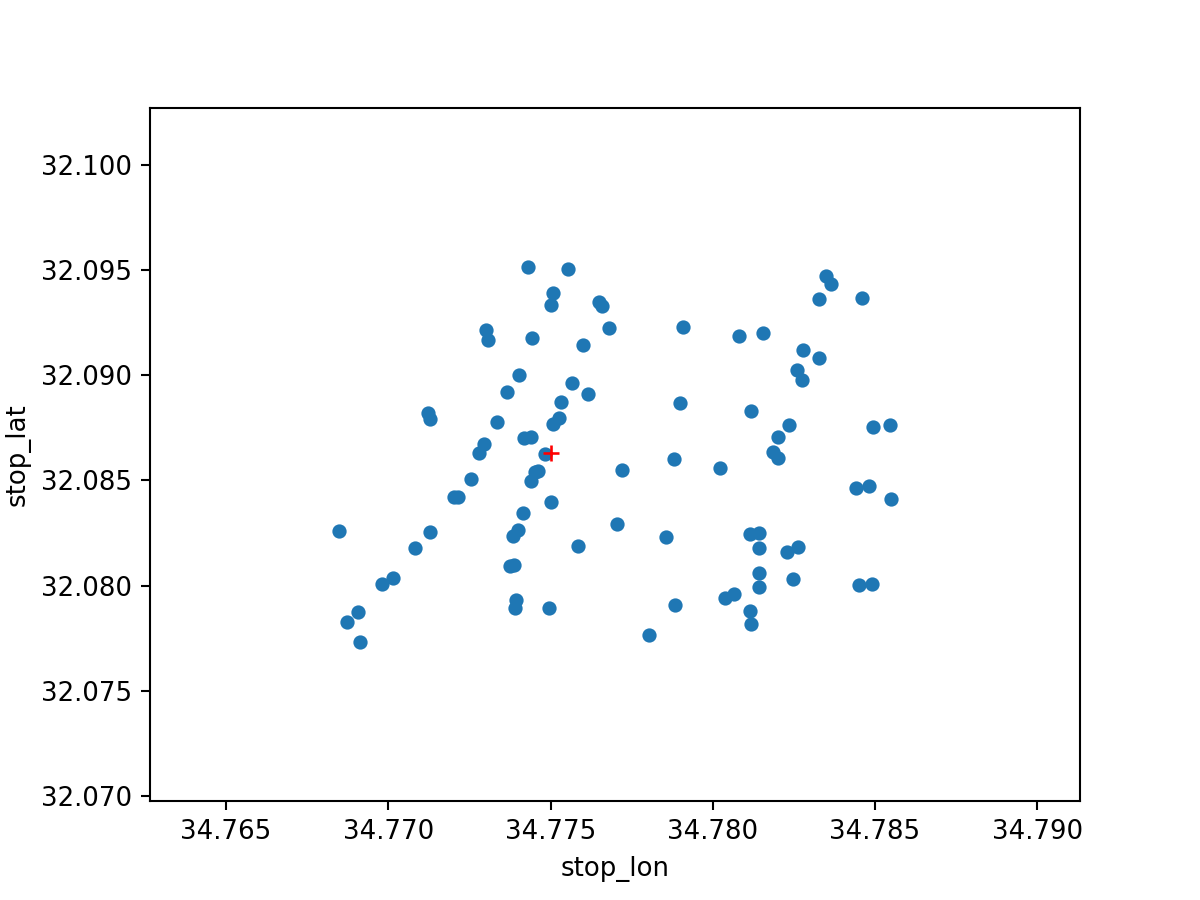

In [2]:
selected = data[data.stop_lon < east][data.stop_lon > west][data.stop_lat < north][data.stop_lat > south]\
               .filter(items=['stop_lat', 'stop_lon'])

def plot_stops(ax=None):
    selected.plot(ax=ax, kind="scatter", x="stop_lon", y="stop_lat")
    plt.plot(HERE[1], HERE[0], 'r+')
plot_stops()  # I'll use it again later
plt.show()

In [3]:
# Let's quickly model this in SQL Alchemy
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Unicode, Float, Boolean, Integer
Base = declarative_base()

class Stop(Base):
    """  https://developers.google.com/transit/gtfs/reference/#stopstxt """
    __tablename__ = 'stops'

    stop_id = Column(Integer, primary_key=True)  # internal ID
    stop_code = Column(Unicode, index=True)      # code on the stop sign
    stop_name = Column(Unicode)                  # human readable
    stop_desc = Column(Unicode)                  # address
    stop_lat = Column(Float)
    stop_lon = Column(Float)
    location_type = Column(Integer)              # 0 = stop, 1 = station, 2 = station enterance
    parent_station = Column(Integer)             # for stops inside central stations
    zone_id = Column(Unicode)

    def __repr__(self):
        return f'<Stop #{self.stop_code}>'

In [4]:
class Agency(Base):
    """  https://developers.google.com/transit/gtfs/reference/#agencytxt """
    __tablename__ = 'agency'

    agency_id = Column(Integer, primary_key=True)
    agency_name = Column(Unicode)        # Human readable
    agency_url = Column(Unicode)
    agency_timezone = Column(Unicode)    # Always Asia/Jerusalem
    agency_lang = Column(Unicode)        # Always "he", even though it's wrong

    agency_phone = Column(Unicode)       # Unused
    agency_fare_url = Column(Unicode)    # Unused

    def __repr__(self):
        return f'<Agency {self.agency_id}>'

In [5]:
class Route(Base):
    """  https://developers.google.com/transit/gtfs/reference/#routestxt """
    __tablename__ = 'routes'

    route_id = Column(Integer, primary_key=True)
    agency_id = Column(Integer)                     # Operator
    route_short_name = Column(Unicode, index=True)  # Actual "line number"
    route_long_name = Column(Unicode)
    route_desc = Column(Unicode)                    # Route license number
    route_type = Column(Integer)                    # Bus / rail / etc
    route_color = Column(Unicode)                   # Used wrongly

    def __repr__(self):
        return f'<Route {self.route_id}>'

In [13]:
class Trip(Base):
    """  https://developers.google.com/transit/gtfs/reference/#tripsstxt """
    __tablename__ = 'trips'

    trip_id = Column(Unicode, primary_key=True)
    route_id = Column(Integer, index=True)
    service_id = Column(Integer)                   # Key for the Calendar table
    trip_headsign = Column(Unicode)                # "headsign" = on the front of the bus
    direction_id = Column(Integer)
    shape_id = Column(Integer)                     # Key for the shapes table

    def __repr__(self):
        return f'<Trip {self.trip_id}>'

In [6]:
class StopTime(Base):
    """  https://developers.google.com/transit/gtfs/reference/#stop_timestxt """
    __tablename__ = 'stoptimes'

    trip_id = Column(Unicode, primary_key=True, index=True)
    arrival_time = Column(Unicode, primary_key=True)
    departure_time = Column(Unicode)
    stop_id = Column(Integer, primary_key=True, index=True)
    stop_sequence = Column(Integer, primary_key=True)
    pickup_type = Column(Boolean)
    drop_off_type = Column(Boolean)
    shape_dist_traveled = Column(Unicode)

    def __repr__(self):
        template = '<StopTime trip={0},time={1},stop_id={2},sequence={3}>'
        return template.format(self.trip_id,
                               self.arrival_time,
                               self.stop_id,
                               self.stop_sequence)

In [7]:
class Shape(Base):
    """ https://developers.google.com/transit/gtfs/reference/#shapestxt """
    __tablename__ = 'shapes'
    shape_id = Column(Integer, primary_key=True, index=True)
    shape_pt_lat = Column(Float)
    shape_pt_lon = Column(Float)
    shape_pt_sequence = Column(Integer, primary_key=True)


In [8]:
class Calendar(Base):
    """ https://developers.google.com/transit/gtfs/reference/#calendartxt """
    __tablename__ = 'calendar'
    service_id = Column(Integer, primary_key=True, index=True)
    sunday = Column(Boolean)
    monday = Column(Boolean)
    tuesday = Column(Boolean)
    wednesday = Column(Boolean)
    thursday = Column(Boolean)
    friday = Column(Boolean)
    saturday = Column(Boolean)
    start_date = Column(Integer)
    end_date = Column(Integer)

In [9]:
class Translation(Base):
    """ GTFS Translations - a Google extension to the GTFS spec

    https://developers.google.com/transit/gtfs/reference/gtfs-extensions#translations
    """
    __tablename__ = 'translations'

    trans_id = Column(Unicode, primary_key=True, index=True)
    """ Translation ID - the source string """
    lang = Column(Unicode, primary_key=True)
    """ Translation language code """
    translation = Column(Unicode)
    """ Translated string """

    def __str__(self):
        return self.translation

    def __repr__(self):
        return '<Translation of %s (to %s): %s>' % (self.trans_id, self.lang,
                                                    self.translation)

In [14]:
engine = create_engine("postgresql:///gtfs")
Base.metadata.create_all(engine)
session = sessionmaker(bind=engine)()

# Populating the DB from the CSV files is left as an excercise to the reader
# hint: use psql's copy command

In [11]:
#
# Let's get some info of a nearby stop
#
code = "25787"
stop = session.query(Stop).filter(Stop.stop_code == code).first()


def get_translation(source):
    # Stop name translation? "easy"
    return session.query(Translation.translation)\
                  .filter(Translation.trans_id == source,
                          Translation.lang == "EN")\
                  .scalar()


print(get_translation(stop.stop_name))

Dizengoff/Yodfat


In [15]:
# Let's get the sechedule for this stop
from datetime import date
today = int(date.today().strftime("%Y%m%d"))
today_name = date.today().strftime("%A").lower()

stoptimes = session.query(StopTime, Trip, Calendar, Route).filter(StopTime.stop_id == str(stop.stop_id))\
                                   .join(Trip, Trip.trip_id == StopTime.trip_id)\
                                   .join(Calendar, Trip.service_id == Calendar.service_id)\
                                   .join(Route, Trip.route_id == Route.route_id)\
                                   .filter(Calendar.start_date <= today, Calendar.end_date >= today)

arrivals = []
for stoptime, trip, calendar, route in stoptimes.all():
    if getattr(calendar, today_name): 
        arrivals.append({"time": stoptime.arrival_time,
                         "line": route.route_short_name,
                         "name": route.route_long_name})

for arrival in sorted(arrivals, key=lambda a: a['time']):
    print(arrival)

{'time': '00:06:23', 'line': '72', 'name': "רדינג-תל אביב יפו<->מתחם ג'י/ילדי טהרן-ראשון לציון-12"}
{'time': '00:16:23', 'line': '172', 'name': 'רדינג-תל אביב יפו<->האורגים-חולון-10'}
{'time': '00:51:52', 'line': '61', 'name': "עמידר ר''ג-רמת גן<->כרמלית-תל אביב יפו-20"}
{'time': '01:05:53', 'line': '230', 'name': "מסוף רעננה-רעננה<->ת. מרכזית ת''א/לוינסקי-תל אביב יפו-1#"}
{'time': '01:06:26', 'line': '273', 'name': 'מסוף רידינג-תל אביב יפו<->בית עלמין/שדרות בן גוריון-גדרה-1#'}
{'time': '01:26:53', 'line': '231', 'name': "מסוף קפלן-כפר סבא<->ת. מרכזית ת''א/לוינסקי-תל אביב יפו-1#"}
{'time': '01:35:53', 'line': '230', 'name': "מסוף רעננה-רעננה<->ת. מרכזית ת''א/לוינסקי-תל אביב יפו-1#"}
{'time': '01:36:26', 'line': '273', 'name': 'מסוף רידינג-תל אביב יפו<->בית עלמין/שדרות בן גוריון-גדרה-1#'}
{'time': '02:05:53', 'line': '230', 'name': "מסוף רעננה-רעננה<->ת. מרכזית ת''א/לוינסקי-תל אביב יפו-1#"}
{'time': '02:06:26', 'line': '273', 'name': 'מסוף רידינג-תל אביב יפו<->בית עלמין/שדרות בן גוריון-

93


<IPython.core.display.Javascript object>


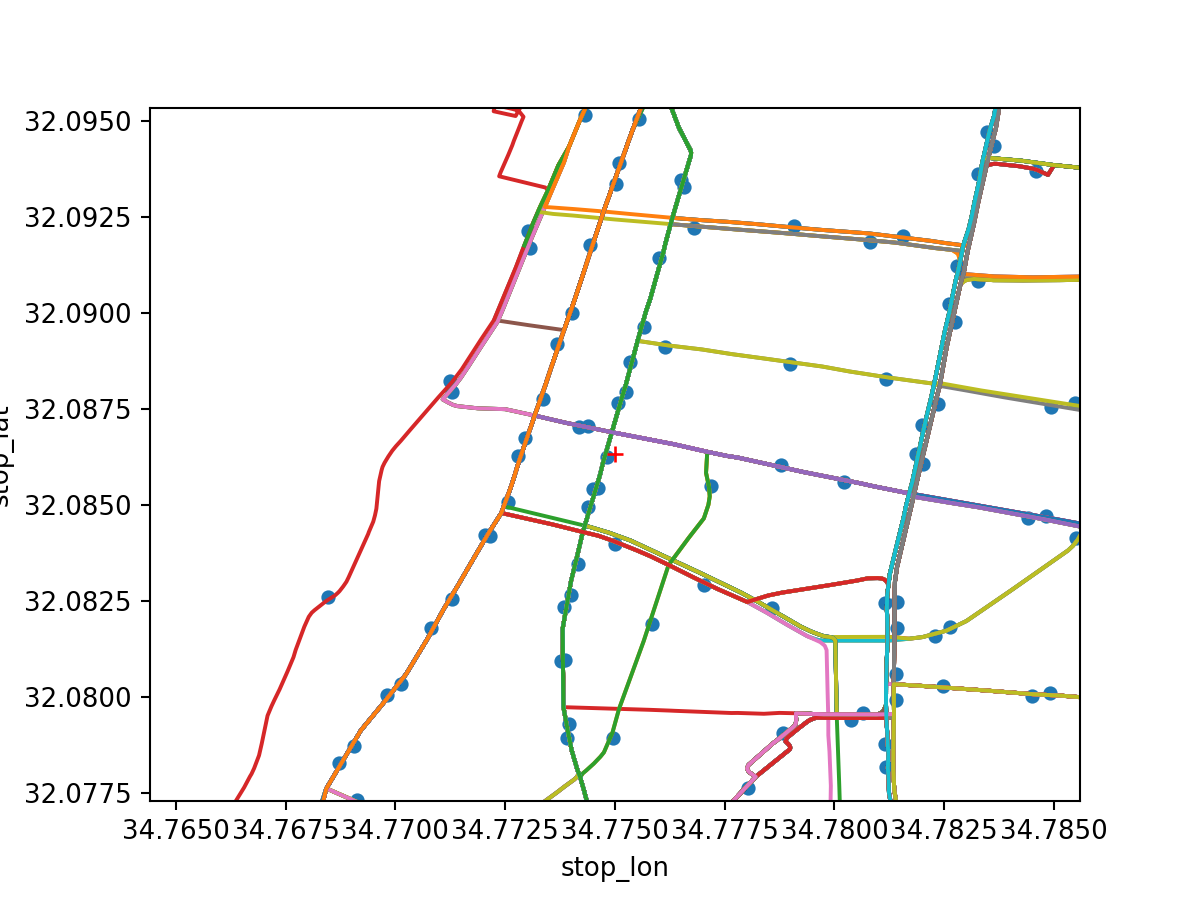

(32.077300911327036, 32.09533707581937)

In [16]:
# How about route shapes?

# 1. Collect all nearby stop IDs (this time with SQL)
stops = session.query(Stop.stop_id).filter(Stop.stop_lon < east,
                                           Stop.stop_lon > west,
                                           Stop.stop_lat < north,
                                           Stop.stop_lat > south).all()

print(len(stops))

# 2. Find all shape IDs for trips that pass in nearby stops
shapes = session.query(Trip.shape_id).join(StopTime, Trip.trip_id == StopTime.trip_id)\
                                    .filter(StopTime.stop_id.in_(stops))\
                                    .distinct()
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()
for i, shape_id in enumerate(shapes.all()):
    shape = session.query(Shape.shape_pt_lon,
                          Shape.shape_pt_lat).filter(Shape.shape_id == shape_id)\
                          .order_by(Shape.shape_pt_sequence)
    ax.plot(*zip(*shape.all()))
    if i % 10 == 0:
        fig.canvas.draw()
    
plot_stops(ax)
fig.canvas.draw()
axes = plt.gca()
axes.set_xlim([west, east])  # Zoom on our area
axes.set_ylim([south, north])

```xml
<SOAP-ENV:Envelope xmlns:SOAP-ENV="http://schemas.xmlsoap.org/soap/envelope/" xmlns:SOAP-ENC="http://schemas.xmlsoap.org/soap/encoding/" xmlns:acsb="http://www.ifopt.org.uk/acsb" xmlns:datex2="http://datex2.eu/schema/1_0/1_0" xmlns:ifopt="http://www.ifopt.org.uk/ifopt" xmlns:siri="http://www.siri.org.uk/siri" xmlns:siriWS="http://new.webservice.namespace" xmlns:xsd="http://www.w3.org/2001/XMLSchema" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="./siri">
    <SOAP-ENV:Header />
    <SOAP-ENV:Body>
        <siriWS:GetStopMonitoringService>
            <Request xsi:type="siri:ServiceRequestStructure">   
                <siri:RequestTimestamp>2018-07-13T18:12:12.951715+03:00</siri:RequestTimestamp>                
                <siri:RequestorRef xsi:type="siri:ParticipantRefStructure">[USER NAME]</siri:RequestorRef>                
                <siri:MessageIdentifier xsi:type="siri:MessageQualifierStructure">[USER NMAE]:1531494732.9517748</siri:MessageIdentifier>
                <siri:StopMonitoringRequest version="IL2.71" xsi:type="siri:StopMonitoringRequestStructure">    
                    <siri:RequestTimestamp>2018-07-13T18:12:12.951715+03:00</siri:RequestTimestamp>   
                    <siri:MessageIdentifier xsi:type="siri:MessageQualifierStructure">0</siri:MessageIdentifier>    
                    <siri:PreviewInterval>PT30M</siri:PreviewInterval>
                    <siri:MonitoringRef xsi:type="siri:MonitoringRefStructure">25324</siri:MonitoringRef> 
                    <siri:MaximumStopVisits>50</siri:MaximumStopVisits>
                </siri:StopMonitoringRequest>
            </Request>
        </siriWS:GetStopMonitoringService>
    </SOAP-ENV:Body>
</SOAP-ENV:Envelope>
```

```xml
<?xml version='1.0' encoding='UTF-8'?>
<S:Envelope xmlns:S="http://schemas.xmlsoap.org/soap/envelope/">
    <S:Body>
        <ns7:GetStopMonitoringServiceResponse xmlns:ns3="http://www.siri.org.uk/siri" xmlns:ns4="http://www.ifopt.org.uk/acsb" xmlns:ns5="http://www.ifopt.org.uk/ifopt" xmlns:ns6="http://datex2.eu/schema/1_0/1_0" xmlns:ns7="http://new.webservice.namespace">
            <Answer>
                <ns3:ResponseTimestamp>2018-07-13T17:43:48.653+03:00</ns3:ResponseTimestamp>
                <ns3:ProducerRef>ISR Siri Server (141.12)</ns3:ProducerRef>
                <ns3:ResponseMessageIdentifier>19686869</ns3:ResponseMessageIdentifier>
                <ns3:RequestMessageRef>[USERNAME REDACTED]:1531493050.8894157</ns3:RequestMessageRef>
                <ns3:Status>true</ns3:Status>
                <ns3:StopMonitoringDelivery version="IL2.71">
                    <ns3:ResponseTimestamp>2018-07-13T17:43:48.653+03:00</ns3:ResponseTimestamp>
                    <ns3:Status>true</ns3:Status><ns3:MonitoredStopVisit>
                    <ns3:RecordedAtTime>2018-07-13T17:43:39.000+03:00</ns3:RecordedAtTime>
                    <ns3:ItemIdentifier>1165006787</ns3:ItemIdentifier>
                    <ns3:MonitoringRef>25324</ns3:MonitoringRef>
                    <ns3:MonitoredVehicleJourney>
                        <ns3:LineRef>9802</ns3:LineRef>
                        <ns3:DirectionRef>1</ns3:DirectionRef>
                        <ns3:FramedVehicleJourneyRef>
                            <ns3:DataFrameRef>2018-07-13</ns3:DataFrameRef>
                            <ns3:DatedVehicleJourneyRef>33453302</ns3:DatedVehicleJourneyRef>
                        </ns3:FramedVehicleJourneyRef>
                        <ns3:PublishedLineName>142</ns3:PublishedLineName>
                        <ns3:OperatorRef>5</ns3:OperatorRef>
                        <ns3:DestinationRef>37109</ns3:DestinationRef>
                        <ns3:OriginAimedDepartureTime>2018-07-13T17:05:00.000+03:00</ns3:OriginAimedDepartureTime>
                        <ns3:VehicleLocation>
                            <ns3:Longitude>34.771053314208984</ns3:Longitude>
                            <ns3:Latitude>32.054786682128906</ns3:Latitude>
                        </ns3:VehicleLocation>
                        <ns3:VehicleRef>7743</ns3:VehicleRef>
                        <ns3:MonitoredCall>
                            <ns3:StopPointRef>25324</ns3:StopPointRef>
                            <ns3:ExpectedArrivalTime>2018-07-13T17:46:00.000+03:00</ns3:ExpectedArrivalTime>
                        </ns3:MonitoredCall>
                    </ns3:MonitoredVehicleJourney>
                </ns3:MonitoredStopVisit>
                </ns3:StopMonitoringDelivery>
            </Answer>
        </ns7:GetStopMonitoringServiceResponse>
    </S:Body>
</S:Envelope>
```

In [18]:
# Let's show live arrivals!
import siri
stop_code="25787"
response = siri.client.request([stop_code])
print(response.errors)
for visit in response.visits[stop_code]:
    print(f"{visit.line_name}: {visit.eta.strftime('%H:%M')}")


[]
172: 12:26
66: 12:27
129: 12:28
72: 12:31
61: 12:32
66: 12:32
172: 12:32
172: 12:40
72: 12:42
72: 12:42
66: 12:46
129: 12:48


In [19]:
# bus locations? Sure!

# Draw our previous map again, this time with leaflet
import time
from ipyleaflet import Map, CircleMarker, basemaps
m = Map(center=HERE, zoom=12, basemap=basemaps.Hydda.Full)
display(m)

stop_codes = ["23013", # ת. מרכזית ת''א ק. 7/הורדה
              "24090", # ת. מרכזית ת''א/לוינסקי
              "25070", # ת. מרכזית ת''א/לוינסקי
              "25477", # ת. מרכזית ת''א/לוינסקי
              "26953", # ת. מרכזית ת''א ק. 4/הורדה
              "28627", # ת. מרכזית ת''א ק. 6/הורדה
              "25324", # K. Galoyot / Salame
              "25325", # Salame / Elifelt
              "26956", "26957", "26959", "26961", "26963", "27086", # Carmelit
              "20506", # Golomb
              "25385", # Eilat / Sahlosh
              "25787", # Diezengoff / Yodfat
              "20364", # Diezengoff / Yodfat
              "20348", # Namir / Jabotinsky
              "25935", "20594" # Terminal 2000
              "25305" # Jerusalem / Yehoda Hayamit
             ]

stops = session.query(Stop).filter(Stop.stop_code.in_(stop_codes)).all()

for stop in stops:
    # mark stops
    cm = CircleMarker(location=(stop.stop_lat, stop.stop_lon), radius=2, weight=2,
                      color='blue', opacity=0.4)
    m.add_layer(cm)
stop_codes = [stop.stop_code for stop in stops]

vehicles = {}

a = True
while a:
    for group in siri._grouper(stop_codes, 10):  # process 10 stops at a time
        group = list(filter(None, group))  # remove None values
        try:
            response = siri.client.request(group)
        except Exception as e:
            print(e)
            time.sleep(0.2)
            continue
        for stopcode, visits in response.visits.items():
            for visit in visits:
                if not visit.location:
                    continue
                latlon = (float(visit.location['lat']), float(visit.location['lon']))
                if visit.vehicle_ref in vehicles:
                    vehicles[visit.vehicle_ref].location=latlon
                else:
                    cm = CircleMarker(location=latlon, radius=3, weight=2,
                                      fill_color='red', color='red', opacity=1.0, fill_opacity=1.0)
                    m.add_layer(cm)
                    vehicles[visit.vehicle_ref] = cm
        time.sleep(0.8)
    print("l")
    time.sleep(2)

Map(basemap={'url': 'http://{s}.tile.openstreetmap.se/hydda/full/{z}/{x}/{y}.png', 'max_zoom': 18, 'attributio…

l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l
l


KeyboardInterrupt: 